# River flow

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)

/home/dev/miniconda3/envs/pf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/200cases.csv')
df.head(5)

,HOUR,RES-A,THXD,TLKXD,HEXD,CXXD,LIXD,HGXD,YUXD,ZIXD,CNXD,LCXD,PUXD,POI
0,0,24.063760,3.942676,0.230286,1.148205,1.625466,0.175044,1.176756,3.669074,4.610227,2.792007,2.397445,2.478524,23.920
1,1,24.253189,1.131599,0.437430,1.331452,3.480356,0.537591,3.602246,3.444780,4.066903,3.570329,0.048181,1.942490,34.225
2,2,23.112764,3.612339,0.320203,1.440068,3.440144,2.183202,2.799458,2.747221,4.248959,0.501656,4.080552,1.830848,30.505
3,3,28.529233,9.189411,2.044259,15.609019,9.414076,24.690238,4.182744,3.653064,21.215918,2.314173,4.732400,2.459176,23.414
4,4,83.044822,33.405864,20.699138,56.167025,48.559899,57.120491,54.318240,26.081434,67.467892,9.500927,42.796349,16.506396,20.571


In [3]:
df.shape

(14400, 14)

In [3]:
# pre-processing
X, y = df.drop(columns=['HOUR', 'POI']), df['POI'].values
X.shape, y.shape

((14400, 12), (14400,))

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [5]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences) // n_steps):
        # find the end of the input, output sequence
        start_ix = i * n_steps
        end_ix = (i + 1) * n_steps

        # check if we are beyond the dataset
        # if end_ix > len(input_sequences): break
        # gather input and output of the pattern
        print("x={}-{}".format(start_ix, end_ix))
        seq_x, seq_y = input_sequences[start_ix:end_ix], output_sequence[start_ix:end_ix]
        X.append(seq_x), y.append(seq_y.flatten())
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 72)
print(X_ss.shape, y_mm.shape)

x=0-72
x=72-144
x=144-216
x=216-288
x=288-360
x=360-432
x=432-504
x=504-576
x=576-648
x=648-720
x=720-792
x=792-864
x=864-936
x=936-1008
x=1008-1080
x=1080-1152
x=1152-1224
x=1224-1296
x=1296-1368
x=1368-1440
x=1440-1512
x=1512-1584
x=1584-1656
x=1656-1728
x=1728-1800
x=1800-1872
x=1872-1944
x=1944-2016
x=2016-2088
x=2088-2160
x=2160-2232
x=2232-2304
x=2304-2376
x=2376-2448
x=2448-2520
x=2520-2592
x=2592-2664
x=2664-2736
x=2736-2808
x=2808-2880
x=2880-2952
x=2952-3024
x=3024-3096
x=3096-3168
x=3168-3240
x=3240-3312
x=3312-3384
x=3384-3456
x=3456-3528
x=3528-3600
x=3600-3672
x=3672-3744
x=3744-3816
x=3816-3888
x=3888-3960
x=3960-4032
x=4032-4104
x=4104-4176
x=4176-4248
x=4248-4320
x=4320-4392
x=4392-4464
x=4464-4536
x=4536-4608
x=4608-4680
x=4680-4752
x=4752-4824
x=4824-4896
x=4896-4968
x=4968-5040
x=5040-5112
x=5112-5184
x=5184-5256
x=5256-5328
x=5328-5400
x=5400-5472
x=5472-5544
x=5544-5616
x=5616-5688
x=5688-5760
x=5760-5832
x=5832-5904
x=5904-5976
x=5976-6048
x=6048-6120
x=6120-6192

In [6]:
rows_per_case = 72
total_cases = len(X) // 72
train_test_cutoff = round(0.90 * total_cases)

X_train = X_ss[-(train_test_cutoff):]
X_test = X_ss[:-(train_test_cutoff)]

y_train = y_mm[-(train_test_cutoff):] 
y_test = y_mm[:-(train_test_cutoff)]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (180, 72, 12) (180, 72)
Testing Shape: (20, 72, 12) (20, 72)


In [7]:
from darts import TimeSeries

ts = TimeSeries.from_values(X_train[0])
ts.pd_dataframe()

component,0,1,2,3,4,5,6,7,8,9,10,11
time,,,,,,,,,,,,
0,-0.639872,-0.496016,-0.593217,-0.580830,-0.563339,-0.511953,-0.524930,-0.592141,-0.441274,-0.542101,-0.572695,-0.449997
1,-0.482753,-0.494804,-0.468868,-0.613540,-0.534647,-0.477115,-0.572461,-0.557560,-0.596064,-0.576049,-0.574760,-0.484500
2,-0.622892,-0.448713,-0.543910,-0.527147,-0.618542,-0.528799,-0.479871,-0.589115,-0.493706,-0.634289,-0.620005,-0.534213
3,-0.641044,0.590143,0.417662,-0.544650,-0.605723,-0.582689,-0.460384,-0.437066,-0.369272,-0.484631,-0.363658,-0.451092
4,0.469054,2.226908,2.323000,-0.253895,0.538772,-0.324847,1.037949,0.521010,0.744063,0.763229,0.591252,-0.142954
...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.440817,-0.570938,-0.560310,-0.512136,-0.502738,-0.514345,-0.617648,-0.516431,-0.515604,-0.594952,-0.574091,-0.459873
68,-0.512131,-0.589324,-0.520566,-0.449628,-0.486773,-0.614701,-0.612221,-0.530095,-0.485594,-0.456074,-0.490416,-0.530791
69,-0.531037,-0.448045,-0.469671,-0.547126,-0.575862,-0.441645,-0.526139,-0.631949,-0.532147,-0.603934,-0.475320,-0.608229


In [10]:
from darts import TimeSeries

X_train_snapshots = list()
y_train_snapshots = list()

for i in range(len(X_train)):
    x_snapshot = TimeSeries.from_values(values=X_train[i])
    y_snapshot = TimeSeries.from_values(values=y_train[i])

    X_train_snapshots.append(x_snapshot)
    y_train_snapshots.append(y_snapshot)

# No convarites

In [18]:
model = NBEATSModel(
    input_chunk_length=24, output_chunk_length=24, n_epochs=100, random_state=0
)

model.fit(y_train_snapshots, verbose=True)

Epoch 99: 100%|██████████| 141/141 [00:05<00:00, 24.14it/s, train_loss=8.45e-5] 


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=24, n_epochs=100, random_state=0)

# future covariates

In [96]:
from darts.models import RNNModel

model = RNNModel(input_chunk_length=1, 
                #  model='LSTM',
                 training_length=71, 
                 n_rnn_layers=4,
                 random_state=1)

model.fit(y_train_snapshots, 
          future_covariates=X_train_snapshots, 
          epochs=100, 
          verbose=True)

Epoch 0:  50%|█████     | 3/6 [00:00<00:00, 104.65it/s, train_loss=0.0851]

Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 124.68it/s, train_loss=0.000429]


RNNModel(model=RNN, hidden_dim=25, n_rnn_layers=4, dropout=0.0, training_length=71, input_chunk_length=1, random_state=1)

In [101]:
test_case_ix = 6
_X_test = X_test[test_case_ix]
_y_test = y_test[test_case_ix]
# for i in range(2):
#     _X_test = np.insert(_X_test, 0, 0.1, axis=1)

_X_test.shape

(72, 12)

In [102]:
one_y_test = TimeSeries.from_values(_y_test)
one_x_test = TimeSeries.from_values(_X_test)

In [103]:
_y_test[0]

0.027314373117295808

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.65it/s]
MAPE = 6.99%


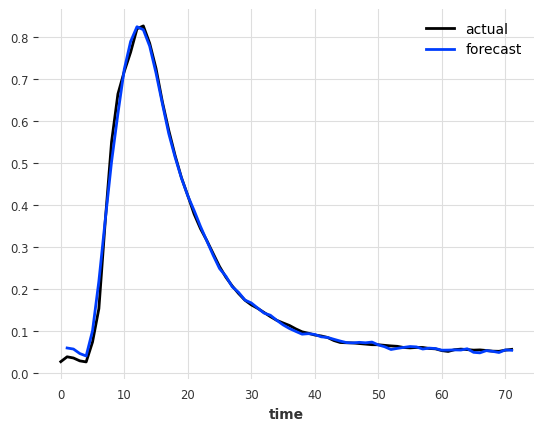

In [104]:
start_y = TimeSeries.from_values(np.array([_y_test[0]]))
pred = model.predict(n=71, series=start_y, future_covariates=one_x_test)

one_y_test.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(one_y_test, pred)))